In [2]:
%reload_ext autoreload
#!pip install -r requirements.txt

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
600
torch.Size([100, 3])


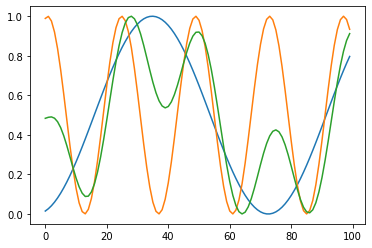

In [3]:
%autoreload
from architectures.RTSGAN import *
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)
alpha = 0.7
noise = 0

trainset = DatasetSinus(num=6_000, seq_len=100, alpha=alpha, noise=noise)
testset = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)
#stocks_data = google_data_loading(100)

#trainset =DatasetStocks(stocks_data[:-300])
#testset =DatasetStocks(stocks_data[-300:])
print(len(testset))
print(testset[0][0].size())
import matplotlib.pyplot as plt
plt.plot(trainset[1][0]);

In [4]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/RTSGAN",
    name="rtsgan",
    tags=["beta_0=0"],
    description="beta_0=0",
    source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rtsgan.pt",
    "n_epochs": 500,
    "l_rate": 0.001,
    "l_rate_g": 0.001,
    "l_rate_ae": 0.001,
    "batch_size": 128,
    "d_steps": 10,
    "num_layers": 2, # only affects the autoencoder
    "hidden_dim": 40,
    "spectralnorm": False, # USE Gradient-penalty instead
    "optimizer": "RMSprop", # RMSprop, Adam
    "dis_thresh": 0.15,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
    "optimizer_ae": "Adam",
}
params["Z_dim"] = (params["num_layers"] +1) * params["hidden_dim"]
run["parameters"] = params
run["dataset"] = {"alpha":alpha, "noise":noise}

model = RTSGAN(params)
rtsgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=run, continue_training=False)

# Generate random synthetic data
gen_z = rtsgan_generator(model, params)


log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

from metrics import compare_sin3_generation, sw_approx
np.random.seed(41)
testset2 = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)
params["testset_size"] = 1000
fake_data = rtsgan_generator(model, params)

mse_error = compare_sin3_generation(fake_data, alpha, noise)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]
#wass_dist = sinkhorn_distance(x,y)
#mmd = MMD(x,y)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

run.stop()

https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-151
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Using optimizer: RMSprop

Start Embedding Network Training


Epoch: 349, Loss: 0.0002: 100%|██████████| 350/350 [06:17<00:00,  1.08s/it]



Start GAN Training


Epoch: 499, G: -0.6141, D: -0.1012: 100%|██████████| 500/500 [06:10<00:00,  1.35it/s]


Training Complete and model_rtsgan.pt saved

Generating Data...Done


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Real std:  [0.9620537 0.9402171]
Fake std:  [0.22142182 0.25374544]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]

Generating Data...Done
MSE Error: 0.00758
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.


/notebooks/master-GAN/TimeGAN/metrics.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  sins3_fake = torch.tensor(sins3_fake)


All 27 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-151


In [17]:
gen_z = rtsgan_generator(model, params)


Generating Data...Done


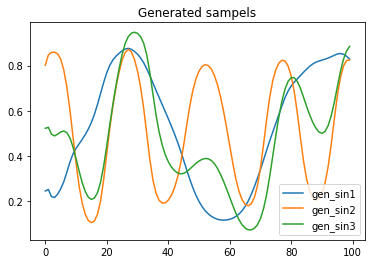

In [19]:
sample = 1
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

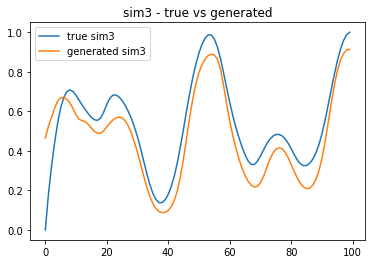

In [20]:
sample = 4
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], alpha=alpha, noise=noise)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

In [ ]:
%autoreload
from metrics import compare_sin3_generation
compare_sin3_generation(gen_z, 0.7, 0)

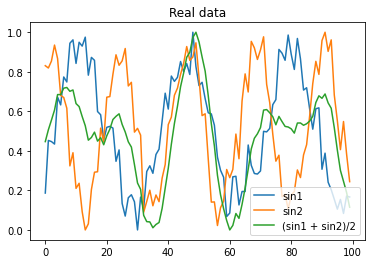

In [21]:
sample = trainset.__getitem__(2)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()